<a href="https://colab.research.google.com/github/julie-dfx/causal-decision-analytics/blob/main/00_reboot_07_hypothesis_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypothesis testing from first principles

## Business question
Does issuing compensation improve 28-day retention, or could the observed difference be explained by random variation alone?

## Statistical question
How surprising would the observed data be if compensation had no effect?

## Define null world: Null Hypothesis (H0)

Issuing compensation has no effect on retention. Any observed difference is due to random variation.

The null is a data-generating world, not an opinion

In [ ]:
# Simulate null world
import numpy as np

#Assume retention is the same regardless of compensation
n = 1000
true_retention_rate = 0.60

#simulate 2 groups under the null
ret_comp = np.random.binomial(1, true_retention_rate, n)
ret_no_comp = np.random.binomial(1, true_retention_rate, n)

observed_diff = ret_comp.mean() - ret_no_comp.mean()
observed_diff

# this is a fake universe where the null hypothesis is true

np.float64(0.039000000000000035)

In [ ]:
#repeat the null world many times

diffs = []

for _ in range(5000):
  ret_comp = np.random.binomial(1, true_retention_rate, n)
  ret_no_comp = np.random.binomial(1, true_retention_rate, n)
  diffs.append(ret_comp.mean() - ret_no_comp.mean())

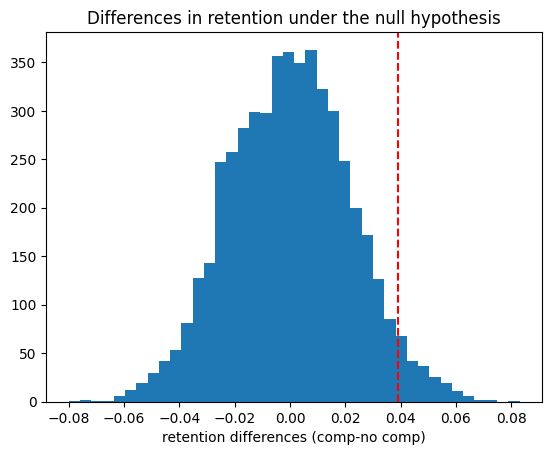

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(diffs, bins=40)
plt.axvline(observed_diff, color='red', linestyle='--')
plt.title('Differences in retention under the null hypothesis')
plt.xlabel("retention differences (comp-no comp)")
plt.show()

#most differences cluster around zero
#some differences are larger just by chance
#the question is: is what we observed rare in this null world?

## Mental model:

A hypothesis test asks:
"If the null hypothesis were true, how unsure would this data be?"
It does not ask "Is the null hypothesis true"

## Null and alternative worlds

HO: Compensation has no effect on retention
H1: Compensation improves retention

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(22)
n = 1000
baseline = 0.60
effect = 0.03 #3pp improvement under H1

#null worlds
diffs_null = []
#alternative world
diffs_alt = []

for _ in range(5000):
  #HO
  ret_comp = np.random.binomial(1, baseline, n)
  ret_no_comp = np.random.binomial(1, baseline, n)
  diffs_null.append(ret_comp.mean() - ret_no_comp.mean())

  #H1
  ret_comp = np.random.binomial(1, baseline + effect, n)
  ret_no_comp = np.random.binomial(1, baseline, n)
  diffs_alt.append(ret_comp.mean() - ret_no_comp.mean())

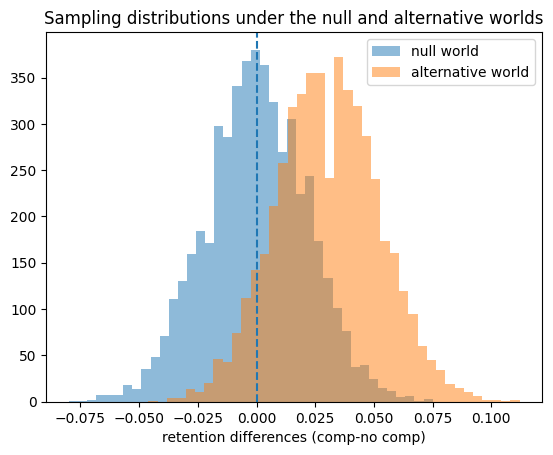

In [ ]:
plt.figure()
plt.hist(diffs_null, bins=40, alpha=0.5, label='null world')
plt.hist(diffs_alt, bins=40, alpha=0.5, label='alternative world')
plt.axvline(0.0, linestyle="--")
plt.legend()
plt.title('Sampling distributions under the null and alternative worlds')
plt.xlabel("retention differences (comp-no comp)")
plt.show()

In [ ]:
#intrduce a decision threshold
threshold = 0.015

#compute errors
type1 = np.mean(np.array(diffs_null) > threshold) #rejecting H0 when H0 is true ie believing comp works when it doesnt (wasted money)
type2 = np.mean(np.array(diffs_alt) <= threshold) #failing to reject H0 when H1 is true ie believing comp doenst work when it actually does (lost opportunity)

print(f"Type 1 error: {type1}, Type 2 error: {type2}")

Type 1 error: 0.2504, Type 2 error: 0.2336


## Interpretation

Choosing a significance threshold is a risk management decision.
Lower thresholds reduce false positives but increase false negatives.
The appropriate balance depends on the relative costs of these errors

In [ ]:
observed = 0.022 #pretend this is what we observed in real data (real world)

p_value = np.mean(np.array(diffs_null) >= observed) #faction of null-world outcomes as/more extreme than observed
p_value

np.float64(0.161)

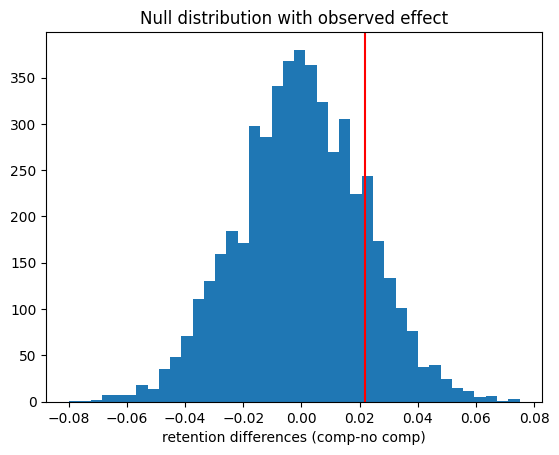

In [ ]:
#visuallise it

plt.figure()
plt.hist(diffs_null, bins=40)
plt.axvline(observed, color='red')
plt.title("Null distribution with observed effect")
plt.xlabel("retention differences (comp-no comp)")
plt.show()


#red line = what happened (observed)
#histogram = what usually happens if null is true
#p-value = area to the right of the red line

## Definition of a p-value

The p-value is the probability of observing a result at least as extreme as the one obtained, assuming the null hypothesis is true

## Mental Model

A p-value measures how incompatible the observed data is with the null world.
It does not measure how true or false the null hypothesis is

# T-tests

Can we compute that null distribution analytically instead of simulating it ?

The raw differences are not enough, because "is difference 0.03 enough ?" depends on sample size and variance.

The t-statistic represents signal/noise

t = observed signal / estimated standard error --> how many standard errors away from zero ? how surprising the result is?

In [ ]:
import numpy as np

np.random.seed(24)

n1 = 200
n2 = 200

group1 = np.random.normal(1, 0.63, n1)
group2 = np.random.normal(1, 0.63, n2)

mean1 = group1.mean()
mean2 = group2.mean()

var1 = group1.var(ddof=1) #already squared
var2 = group2.var(ddof=1)

diff = mean1 - mean2

se = np.sqrt(var1/n1 + var2/n2)

t_stat = diff / se

mean1, mean2, diff, se, t_stat

# if we actually KNEW the true population variances, the stadardisez statistic would follow a normal distribution;
# we don't knwo the variances, we simply ESTIMATE them from the data
# that introduces EXTRA uncertainty
# this is why the distribution becomes t-distributed instead of normal

#degrees of freedom ~ how much independant info do we have to estimate variability? you use one df for the mean, so remains n-1 to estimate variance
#df controls how conservative the test is

#small samples -> more uncertainty -> heavier tails
# large samples -> t -> normal

#if df is small -> t distribution is wide, extremes are more likely, p-values are larger
#if df is large -> t~normal, classical z-test behaviour

#welch formuala adjusts df downward when variances are unequal and sample sizes are unequal (df goes down -> more conservative)

(np.float64(1.052676298264133),
 np.float64(0.9298677718805061),
 np.float64(0.12280852638362683),
 np.float64(0.06152551645630946),
 np.float64(1.9960584397667869))

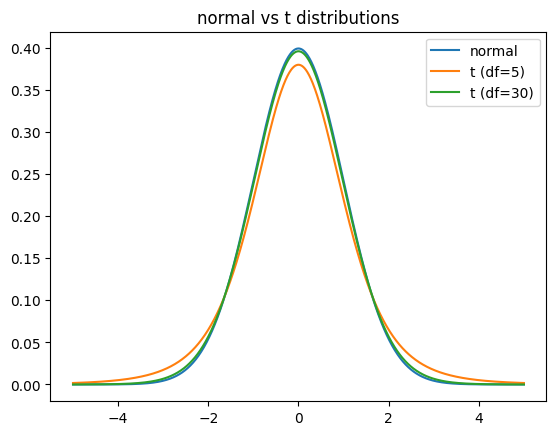

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

x = np.linspace(-5, 5, 1000)

plt.figure()
plt.plot(x, stats.norm.pdf(x), label='normal')
plt.plot(x, stats.t.pdf(x, df=5), label="t (df=5)")
plt.plot(x, stats.t.pdf(x, df=30), label="t (df=30)")
plt.legend()
plt.title("normal vs t distributions")
plt.show()

## Why the t-distribution appears

When population variance is unknown and estimated from the sample, the standardized mean difference follows a t-distribution rather than a normal distribution

The degrees of freedom reflect the amount of independant information available to estimate variance. Smaller samples result in heavier tails and more conservative inference

Welch's t-test adjusts the degrees of freedom when group variances and sizes are unequal.

## Practical interpretation
For large sample sizes, the t-distribution approaches the nirmal distribution. For small samples, accounting for degrees of freedom prevents overly optimistic p-values.

# Basic t-tests

In [ ]:
# basic 2-sample t-test (Welch by default)

from scipy import stats
import numpy as np

np.random.seed(24)

n1 = 200
n2 = 200

group1 = np.random.normal(1, 0.63, n1)
group2 = np.random.normal(1, 0.63, n2)

mean1 = group1.mean()
mean2 = group2.mean()

var1 = group1.var(ddof=1) #already squared
var2 = group2.var(ddof=1)

diff = mean1 - mean2

se = np.sqrt(var1/n1 + var2/n2)

t_stat = diff / se

mean1, mean2, diff, se, t_stat#recreate clean example


(np.float64(1.052676298264133),
 np.float64(0.9298677718805061),
 np.float64(0.12280852638362683),
 np.float64(0.06152551645630946),
 np.float64(1.9960584397667869))

In [ ]:


result = stats.ttest_ind(group1, group2, equal_var=False) #in real life, use Welch unless you have strong reasons not to)
result

#what scipy is doing: computing means, sample vairances, standard error, t-stat, Welch degrees of freedom, p-value

TtestResult(statistic=np.float64(1.9960584397667869), pvalue=np.float64(0.04660899107677746), df=np.float64(397.71068436114825))

In [ ]:
t_stat = result.statistic
p_val = result.pvalue

t_stat, p_val # aligned with manual calc

(np.float64(1.9960584397667869), np.float64(0.04660899107677746))

In [ ]:
#One-sided tests should only be used if you do not care if an efect is in the opposite direction. Rarely justified in real life

In [ ]:
#confidence interval from SciPy (not computed automatically)
mean_diff = group1.mean() - group2.mean()

se = np.sqrt(group1.var(ddof=1)/len(group1) +
             group2.var(ddof=1)/len(group2))

df = result.df

ci_low = mean_diff - stats.t.ppf(0.975, df) * se
ci_high = mean_diff + stats.t.ppf(0.975, df) * se
ci_low, ci_high

# this is how we conect t-statistic, p-value, confidence interval

# t-test is a model of sampling variability; p_value and CI are 2 views of the same object (symetry)
# this is about detectability (not magnitude)



(np.float64(0.0018526412040668766), np.float64(0.2437644115631868))

In [ ]:
# connect to effect size:
pooled_sd = np.sqrt(
    ((len(group1)-1)*group1.var(ddof=1) +
     (len(group2)-1)*group2.var(ddof=1)) /
    (len(group1) + len(group2)-2)
)

cohens_d = mean_diff / pooled_sd
cohens_d

# magnitude
# independent of sample size

np.float64(0.1996058439766787)

## Using SciPy for t-tests

The scipy.stats.ttest_ind function implements Welch's t-test by default when equal_var=False. It computes the standardized mean difference, adjusts degrees of freedom, and returns the corresponding p-value.

Confidence intervals and p-values are derived from the same t-distribution. Effect sizes such as Cohen's d provide magnitude information independant of statistical significance.

# E2E Statistical Case
design -> estimation -> interpretation





## Business Question
Should we increase comnesation issuance after order issue to improve 28-day retention?

## Decision Context
Compesnation costs money. Increasing issuance only makes sense if the incremental retention gain exceeds the costs of compensations

## Statistical question
Is the observed retention difference statistically distinguishable from zero under reasonable assumptions?

## Estimand

Average Treatment Effecf on 28 day retention:

ATE = E[Retention | Comp] - E[Retention | No Comp]
This is what we are estimating (causal contrast)


## Experimental Design

- Customers with eligible order issues are randomly ssigned
  - treatment: receive comp
  - control: no comp
- Randomization ensures:
  - independance bertween treatment and baseline characteristics
  - no systematic confounding

## Assumptions
- random assignment is correctly implemented
- no interference between users
- retention is measured consistently across groups

## Hypotheses
H0: ATE = 0
H1: ATE <> 0

## Experiment
Assume an AB test was run

In [ ]:
#Generate experiment-style data

import numpy as np
from scipy import stats

np.random.seed(25)

n_control = 1500
n_treat = 1500

baseline_retention = 0.60
true_effect = 0.02 #2pp increase

control = np.random.binomial(1, baseline_retention, n_control)
treatment = np.random.binomial(1, baseline_retention + true_effect, n_treat)

In [10]:
#Compute core stats manually
mean_c = control.mean()
mean_t = treatment.mean()

diff = mean_t - mean_c #average treatment effect

diff


np.float64(0.02400000000000002)

## Interpretation of estimate
The estimated ATE represents the difference in avg retention between treated and control group: 2,4pp

In [11]:
#Compute standard error and t-stat
var_c = control.var(ddof=1)
var_t = treatment.var(ddof=1)

se = np.sqrt(var_c/n_control + var_t/n_treat)

t_stat = diff / se

df = (var_c/n_control +var_t/n_treat)**2 / (
    ((var_c/n_control)**2 / (n_control-1)) +
    ((var_t/n_treat)**2 / (n_treat-1))
)

p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df))

diff, se, t_stat, p_val

(np.float64(0.02400000000000002),
 np.float64(0.017853487517276233),
 np.float64(1.3442751718271295),
 np.float64(0.17896113973165306))

## Interpretation of the t-statistic

The t-statistic measures how many estimated stadard errors the observed aTE is away from zero.

Larger absolute values indicate stronger incompatibility with the null hypotheses.

It measures signal relative to noise (not magnitude). 1.34 is reasonable.

## Interpretation of the p-value
The p-value represents the probabilty of observing an ATE at least as extreme as the one obtained, assuming the true ATE is zero

It does not measure the probability that H0 is true or the probability that comp works

in this case, 0.17

In [ ]:
# 95% CI

ci_low = diff - stats.t.ppf(0.975, df) * se
ci_high = diff + stats.t.ppf(0.975, df) * se
ci_low, ci_high

(np.float64(-0.011006326893401482), np.float64(0.059006326893401524))

## Interpretation of the confidence interval

The 95% confidence interval provides a range of ATE values compatible with the observed data under repeated sampling,

If the interval excludes zero, the null hypothesis is rejected at the 5% significance level.

CI an p-value tell the same story, just framed differently.

In [ ]:
# Compute effect size (Cohen's D)

pooled_sd = np.sqrt(
    ((n_control-1)*var_c +(n_treat-1)*var_t) /
    (n_control + n_treat - 2)
)

cohen_d = diff / pooled_sd

cohen_d

np.float64(0.04908598900692347)

## Three distinct quantities
1. Statistical significance -> data compatibility with null
2. Effect size -> magnitude of estimated impact
3. Economic value -> financial consequence of effect

Yhe are related but distinct

## Business translation

### Translate error types into costs
Assume:
- compensation cost per user: 5 EUR
- Incr 26-day revenue per retained user:  30 EUR

If uplift ~2pp
Expected incremental revenue per treated user: 0.02 * 30 = 0.60 EUR

NEt: 5 - 0.6 = -4.4
economically negative

Compute the break even effect:
5/30 = 0.1667 = 16.7pp --> you need that to break even

### technical results

The estimated retention uplift is 2pp
actual results: (95% CI: [-0.011, 0.059], p = 0.17)
pretend results: (95% CI: [0.011, 0.059], p = 0.02)


The confidence interval excludes zero, indicating statistical evidence against the null hypotheses of no effect

However, the estimated magnitude is econo ically small compared to compensation cost

## Executive summary

While the experiment suggests a statistically detectable increase in retention from compensation, the magnitude of the effect is too small to offset the compesnation costs under current assumptions

Unless compensation drives lon-term downstream revenue beyond 28 days, expanding issuance would reduce margin.

## Key lessons
- Statistical significance does not imply economic viability
- Condifence intervals provide magnitude context
- Error tradeoffs must be evaluated relative to business cost
- Hypothesis testing informs decisions but does not make themn

## Deepening (power mechanics)

### Compute power for detecting 2pp

We assume: baseline = 0.60, true effect = 0.02, two-sided test, alpha = 0.05

In [13]:
#simulate power directly

np.random.seed(42)

n = 1500
baseline = 0.60
true_effect = 0.02
alpha = 0.05

rejections = []

for _ in range(3000):
  control = np.random.binomial(1, baseline, n)
  treatement = np.random.binomial(1, baseline + true_effect, n)

  stat, p = stats.ttest_ind(treatment, control, equal_var=False)
  rejections.append(p < alpha)

power_estimate = np.mean(rejections)
power_estimate #probablity we correctly detect the effect; eg if power ~80% -> we detect the effect 80% of the time

np.float64(0.07833333333333334)

Power interpretation:

Power represents the probability of rejecting the H0 when the true effect exists.
It depends on:
- effect size
- sample size
- variability
- significance level

### What happens if n = 300
now we reduce sample size

In [14]:
n_small = 300

rejections_small = []

for _ in range(3000):
  control = np.random.binomial(1, baseline, n_small)
  treatement = np.random.binomial(1, baseline + true_effect, n_small)

  stat, p = stats.ttest_ind(treatment, control, equal_var=False)
  rejections_small.append(p < alpha)

power_small = np.mean(rejections_small)
power_small

#power drops from 78% to 6%; significant drop

np.float64(0.05566666666666667)

Interpretation:
we have the same true effect, the same test; only the sample size has changed
This shows that a non significant result with small n does NOT mean no effect; it may mean we didnt have enough resolution to detect it



Sample size sensitivity:
Reducing sample size substantiually decreases power, even when the true effect remains unchanged

### Required sample size for detecting 1pp
analytical power calculation


In [15]:
from statsmodels.stats.power import TTestIndPower

In [16]:
analysis = TTestIndPower()

effect_size = 0.01 / np.sqrt(baseline*(1-baseline))

#standardised effect size ~ difference / pooled SD

In [18]:
#compute sample size
required_n = analysis.solve_power(
    effect_size=effect_size,
    power=0.8,
    alpha=0.05,
    alternative='two-sided'
)

required_n

# that gives a per-group sample size (n= 37k, very large number)

37675.490833730386

Interpretation: some effects are expensive to detect. 1pp uplift sounds small. In order to statistically detect it reliably, it requires large sample, high power, high precision.

### Conceptual takeways: Power insights
- Power increases with effect size
- Power increases with sample size
- Small effects require large experiments
- Underpowered studies often produce non-significant results even when real effects exist
